# Nextbit Test

### Data description
`deaths.csv` contains US data, for 1997-2002, from police-reported car crashes in which there is a harmful event (people or property), and from which at least one vehicle was towed. Data are restricted to front-seat occupants, include only a subset of the variables recorded, and are restricted in other ways also.

**Format:**
A data frame with 26217 observations on the following 15 variables.

- `dvcat`: ordered factor with levels (estimated impact speeds) 1-9km/h, 10-24, 25-39, 40-54, 55+
- `weight`:
observation weights, albeit of uncertain accuracy, designed to account for varying sampling probabilities.
- `dead`:
factor with levels alive dead
- `airbag`:
a factor with levels none airbag
- `seatbelt`:
a factor with levels none belted
- `frontal`:
a numeric vector; 0 = non-frontal, 1=frontal impact
- `sex`:
a factor with levels f m
- `ageOFocc`:
age of occupant in years
- `yearacc`:
year of accident
- `yearVeh`:
Year of model of vehicle; a numeric vector
- `abcat`:
did one or more (driver or passenger) airbag(s) deploy? This factor has levels deploy nodeploy unavail
- `occRole`:
a factor with levels driver pass
- `deploy`:
a numeric vector: 0 if an airbag was unavailable or did not deploy; 1 if one or more bags deployed.
- `injSeverity`:
a numeric vector; 0:none, 1:possible injury, 2:no incapacity, 3:incapacity, 4:killed; 5:unknown, 6:prior death
- `caseid`:
character, created by pasting together the populations sampling unit, the case number, and the vehicle number. Within each year, use this to uniquely identify the vehicle.

### Exercises
- **E1.** Develop different models to predict the variable `dead` (alive or dead). Explain your choices.
- **E2.** Select the best model and explain your choice.
- **E3.** *(optional)* Train a neural network to predict the variable `dead`. Explain your choices. Did you achieve a better performance with respect to the model selected in **E2.**? Why?

### Classifier: Logistic Regression

I have chosen this kind of classifier since it is a binary classification problem

In [1]:
import numpy as np
import pandas as pd

np.random.seed(123)

In [2]:
X = pd.read_csv("deaths.csv") # read the csv
X.drop(['Unnamed: 0'], axis=1, inplace=True)
X.head() # visualize data frame head

,dvcat,weight,dead,airbag,seatbelt,frontal,sex,ageOFocc,yearacc,yearVeh,abcat,occRole,deploy,injSeverity,caseid
0,25-39,25.069,alive,none,belted,1,f,26,1997,1990.0,unavail,driver,0,3.0,2:3:1
1,10-24,25.069,alive,airbag,belted,1,f,72,1997,1995.0,deploy,driver,1,1.0,2:3:2
2,10-24,32.379,alive,none,none,1,f,69,1997,1988.0,unavail,driver,0,4.0,2:5:1
3,25-39,495.444,alive,airbag,belted,1,f,53,1997,1995.0,deploy,driver,1,1.0,2:10:1
4,25-39,25.069,alive,none,belted,1,f,32,1997,1988.0,unavail,driver,0,3.0,2:11:1


In [3]:
X.isnull().sum() # check for missing values

# injSeverity and yearacc has missing values

dvcat            0
weight           0
dead             0
airbag           0
seatbelt         0
frontal          0
sex              0
ageOFocc         0
yearacc          0
yearVeh          1
abcat            0
occRole          0
deploy           0
injSeverity    153
caseid           0
dtype: int64

In [4]:
X['dead'].value_counts() # the target class is imbalanced.

# I wanted to first train the model without any upsampling of minority class
# or downsampling of majority class to see how the classifier performs on 
# imbalanced dataset.

alive    25037
dead      1180
Name: dead, dtype: int64

### Imputing missing value

I have chosen to impute the missing values for variable 'injSeverity' because there are a considerables no.of rows with missing value for Series 'injSeverity'


In [5]:
# impute missing values with 5.0 or 'unknown' values since 
X.loc[X["injSeverity"].isnull(), "injSeverity"] = 5.0

In [6]:
# drop row(s) containing missing values. One missing value
# for the variable 'yearVeh' is dropped
X.dropna(how='any', inplace=True)

### Modify categorical values for ease of defining dummy variables

In [7]:
X.replace({
    '1-9km/h': '1_to_9',
    '10-24': '10_to_24',
    '25-39': '25_to_39',
    '40-54': '40_to_54',
    '55+': '55_plus'
}, inplace=True)

### Creating dummy variables to handle categorical variables

In [8]:
dummies_list = ['dvcat', 'airbag', 'seatbelt', 'sex', 'abcat', 'occRole']
X = pd.get_dummies(X, columns=dummies_list, drop_first=True)

### Label Encoding
The target variable is label encoded

In [9]:
# dead column
X['dead'] = X.dead.map({'alive': 1, 'dead': 0})

In [10]:
X.head()

,weight,dead,frontal,ageOFocc,yearacc,yearVeh,deploy,injSeverity,caseid,dvcat_1_to_9,dvcat_25_to_39,dvcat_40_to_54,dvcat_55_plus,airbag_none,seatbelt_none,sex_m,abcat_nodeploy,abcat_unavail,occRole_pass
0,25.069,1,1,26,1997,1990.0,0,3.0,2:3:1,0,1,0,0,1,0,0,0,1,0
1,25.069,1,1,72,1997,1995.0,1,1.0,2:3:2,0,0,0,0,0,0,0,0,0,0
2,32.379,1,1,69,1997,1988.0,0,4.0,2:5:1,0,0,0,0,1,1,0,0,1,0
3,495.444,1,1,53,1997,1995.0,1,1.0,2:10:1,0,1,0,0,0,0,0,0,0,0
4,25.069,1,1,32,1997,1988.0,0,3.0,2:11:1,0,1,0,0,1,0,0,0,1,0


In [11]:
Y = X.pop('dead') # target values

In [12]:
# divide the dataset into train and test set.
# train set will be used to build the model
# test set will be used to evaluate the model

# stratified split is used to preserve the ratio between the majority
# and minority class
from sklearn.model_selection import StratifiedShuffleSplit

ss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=2)
for train_index, test_index in ss.split(X, Y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.loc[train_index,], X.loc[test_index,]
    y_train, y_test = Y.loc[train_index,], Y.loc[test_index,]
    
X_train = pd.concat([X_train, y_train], axis=1)

# drop the unique identifier 'caseid'
X_train.drop(['caseid'], axis=1, inplace=True)

X_train.dropna(how='any', inplace=True)

y_train = X_train.pop('dead')

### Logistic Regression Classifier

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score

# using 10-fold cross-validation on the train dataset to find the best
# weighted classifier. Different penalties will be applied on the minority
# class

# 0 being the dead class, which is under-represented, should be penalised more
# for making a wrong prediction

scores_lr = []

for i in range(1, 10):
    clf = LogisticRegression(class_weight={1: 1, 0: i}).fit(X_train, y_train)
    score = cross_val_score(clf, X_train, y_train, cv = 10)
    scores_lr.append(score)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Visualization of classification accuracy with box plots

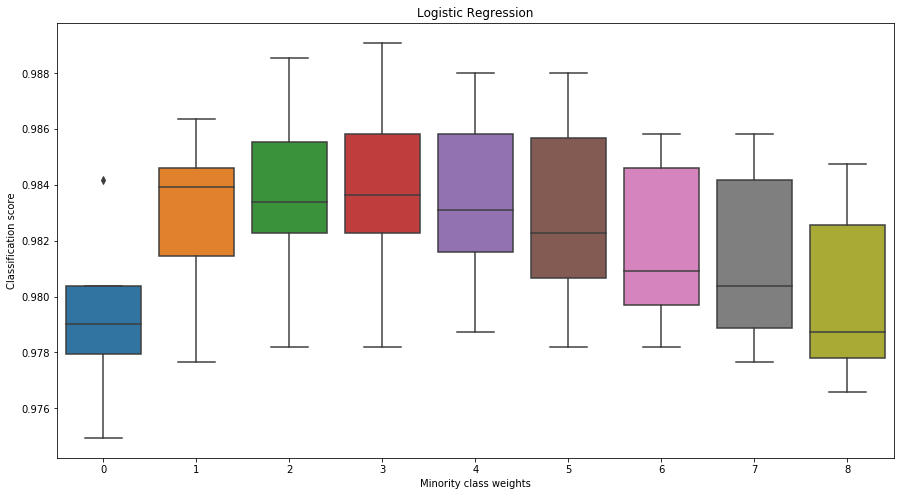

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,8))

sns.boxplot(data=scores_lr)
plt.xlabel('Minority class weights')
plt.ylabel('Classification score')
plt.title('Logistic Regression')
plt.show()

In [15]:
# weight=3 seems to be a resonable choice from the graph
# since it has the highest classfication score

test_id = X_test.pop('caseid') # drop unwanted column

clf = LogisticRegression(class_weight={1: 1, 0: 3}).fit(X_train, y_train)

In [16]:
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

y_pred = clf.predict(X_test)
print("F1-score: {0}".format(f1_score(y_test, y_pred, average='micro'))) # f1-score

F1-score: 0.984106802289


In [17]:
# predict class probability
y_pred_prob = clf.predict_proba(X_test)

y_pred_prob = [p[1] for p in y_pred_prob]

print("AUC-ROC score: {0}".format(roc_auc_score(y_test, y_pred_prob)))

AUC-ROC score: 0.984050632911


In [18]:
# print the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred) # confusion matrix
conf_mat

array([[ 324,   36],
       [  89, 7416]])

In [19]:
y_test.value_counts() # true class counts of the test set

1    7505
0     360
Name: dead, dtype: int64

### Discussion

Since, the dataset is imbalanced, using a logistic regression classifier with equal weights might not be wise. It is because it will always try to vote for the majority class.

Hence, the model must penalise the missclassification of minority class more than the majority class. A class weight of 3 is used for the minority class. In other words, the model penalises a mis-classification of <b>dead</b> class 3 times more than it would penalise a mis-classification of <b>alive</b> class. This approach improves the accuracy.

As we can see, out of 360 <b>dead</b> observations, it is able to correctly classify <b>324</b> observations.